<a id="top"></a>
# Visualización de imágenes DICOM

***
El presente notebook contiene una explicación detallada para el proceso de visualización de imágenes de CT en diferentes planos anatómicos (axial, sagital y coronal) a partir de archivos DICOM.

## Objetivos

```
- Abrir archivos en formato DICOM mediante bibliotecas de Python.
- Extraer la información necesaria para la reconstrucción de imágenes de TC de archivos DICOM.
- Visualizar una imagen de TC.
- Obtención de la matriz en 3D que contengan toda la infomación para la reconstrucción de un examen de TC.
- Visualizar imágenes de TC en los planos axial, sagital y coronal.
```

## Introducción

El notebook se dividirá en 2 fases, la primera fase tiene como objetivo leer un archivo DICOM  y generar una imagen de CT a partir de la matriz de píxeles y de otros atributos extaídos de los archivos, la segunda fase logra integrar el proceso para visualizar una imagen en funciones e implemetarlo para todas las imágenes de un mismo examen con el fin de generar una matriz en 3D que permite la visualización de la anatomía de un paciente en diferentes planos anatómicos. 
>**Nota**: Las funciones que se diseñaron para automatizar ciertos procesos y para que el presente notebook sea más interactivo y fácil de entender, fueron guardadas en el archivo imprimir_imagen.py y son importadas al notebook como **`imp`**.

A continuación se presenta el flujo de trabajo para la visualización de una imagen y de un examen de TC en diferentes planos anatómicos, este flujo de trabajo muestra la estructura que tiene el presente notebook.

<img src="imagenes/Flujo1.png">

## Librerías y módulos


Las bibliotecas que son necesarias para este proyecto son las siguientes:


- *pydicom* para leer los atributos de archivos DICOM.
- *numpy* para la manipulación de las matrices.
- *matplotlib* para gráficar datos.
- *PIL* para manipular imágenes.
- *imprimir_imagen* para manipular imágenes de CT de archivos DICOM.

In [1]:
import pydicom
import numpy as np
import matplotlib.pylab as plt
import PIL
import imprimir_imagen as imp


## Visualización de una imagen de TC

Para la visualización de una imagen de TC se seguirá  el flujo de trabajo que se encuentra en la imagen anterior. Primero se procede  a cargar la imagen y a su posterior lectura, luego se obtiene  la matriz de píxeles de los archivos DICOM, posteriormente se realizarán las debidas transformaciones y correcciones a la matriz de píxeles y finalmente se realizará la visualización.


### Lectura de la imagen de archivos DICOM

En esta sección se lee un archivo DICOM con la biblioteca *pydicom* como un objeto de la clase `pydicom.dataset.FileDataset` que permite extraer la información para la reconstrucción de la imagen de los archivos de una manera fácil. Además se imprimen algunos atributos necesarios para la reconstrucción de la imagen y la clase a la cual pertenecen, la impresión de los datos se lo realizó con fines demostrativos.

In [2]:
ruta_imagen = 'datos-torax-A/paciente3-A/00000036-A' # ruta donde se encuentra la imagen
archivo_dicom = pydicom.dcmread(ruta_imagen) # se lee el archivo DICOM con pydicom
print('------------------------------------------------------------------------------------------------------')
print('VALORES QUE DEFINEN LA MATRIZ DE PIXELES DE UN ARCHIVO DICOM')
print('El archivo DICOM es leído por pydicom como un objeto de la clase', type(archivo_dicom))
matriz_pixeles = archivo_dicom.pixel_array # se lee la matriz de píxeles
print('La matriz de pixeles es un dato de la clase', type(matriz_pixeles), 'con ',
       archivo_dicom.Rows, 'filas', 'y ', archivo_dicom.Columns, 'columnas.')
print('El valor de Samples Per Pixel es de',archivo_dicom.SamplesPerPixel, 
      ' que corresponde a una imagen en escala de grises.' )


------------------------------------------------------------------------------------------------------
VALORES QUE DEFINEN LA MATRIZ DE PIXELES DE UN ARCHIVO DICOM
El archivo DICOM es leído por pydicom como un objeto de la clase <class 'pydicom.dataset.FileDataset'>
La matriz de pixeles es un dato de la clase <class 'numpy.ndarray'> con  512 filas y  512 columnas.
El valor de Samples Per Pixel es de 1  que corresponde a una imagen en escala de grises.


### Obtención de Unidades Hounsfield
Se transforma la matriz de píxeles a unidades Hounsfield, mediante la ecuación que se muestra a continuación, puede encontrar mayor información en la página web de <a href="http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.8.15.3.10.html">Nema</a>.
$$HU = m × SV + b $$
Donde:

- **$HU$**: Matriz de píxeles en unidades Hounsfield, las unidades son dadas por el atributo (0028,1054).

- $b$: Es el intercepto de la ecuación (0028,1052).

- $m$: La pendiendte de la ecuación (0028,1053).

- $SV$: Matriz de Píxeles (0028,9145).

In [3]:
print('------------------------------------------------------------------------------------------------------')
print('VALORES QUE DEFINEN EL CAMBIO DE UNIDADES DE LA MATRIZ DE PIXELES')
print('-Rescale Intercept (0028,1052): ', archivo_dicom.RescaleIntercept)
print('-Tipo de dato de  Rescale Intercept: ', type(archivo_dicom.RescaleIntercept))
print('-Rescale Slope (0028,1053): ', archivo_dicom.RescaleSlope)
print('-Tipo de dato de  RescaleSlope: ', type(archivo_dicom.RescaleSlope))
print('-Rescale Type (0028,1054): ', archivo_dicom.RescaleType)

------------------------------------------------------------------------------------------------------
VALORES QUE DEFINEN EL CAMBIO DE UNIDADES DE LA MATRIZ DE PIXELES
-Rescale Intercept (0028,1052):  -1024
-Tipo de dato de  Rescale Intercept:  <class 'pydicom.valuerep.DSfloat'>
-Rescale Slope (0028,1053):  1
-Tipo de dato de  RescaleSlope:  <class 'pydicom.valuerep.DSfloat'>
-Rescale Type (0028,1054):  HU


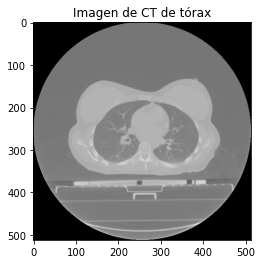

In [4]:
ruta_salida = 'imagenes/' # ruta donde se guardará la imagen
intercept = archivo_dicom.RescaleIntercept 
matriz_pixeles = matriz_pixeles.copy()
slope = archivo_dicom.RescaleSlope
if slope != 1:
    matriz_pixeles = slope * matriz_pixeles
matriz_pixeles += np.int16(intercept)

plt.imshow(matriz_pixeles, cmap=plt.cm.gray)
plt.savefig(ruta_salida +'CT_HU.png',bbox_inches='tight', pad_inches = 0)
plt.title('Imagen de CT de tórax')
plt.show()

### Corrección de píxeles

La gráfica anterior muestra un círculo con un tono mucho más oscuro, esto es debido a que esta zona se encuentra fuera del rango del tomógrafo y este lo llenó con valores arbitrarios. Para saber a qué valores corresponde se puede observar su histograma.

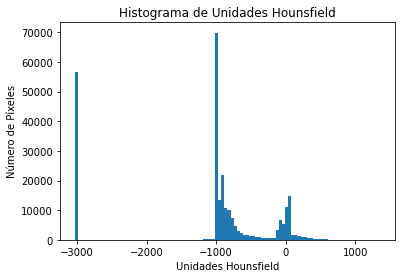

In [5]:
pixeles = np.concatenate((matriz_pixeles), axis=0)
plt.hist(pixeles, bins= 100)
plt.ylabel('Número de Píxeles')
plt.xlabel('Unidades Hounsfield')
plt.title('Histograma de Unidades Hounsfield')
plt.savefig(ruta_salida +'hist_HU.png',bbox_inches='tight')
plt.show()

El tomógrafo proporciona valores entre $-2000HU$ y $4000HU$, por lo que el valor cercano a $3000HU$ es el que corresponde al valor arbitrario, se puede imprimir este valor y saber a qué elemento corresponde exactamente.

In [6]:
print('El valor arbitrario puesto por el tomógrafo es: ', min(pixeles), 'HU')

El valor arbitrario puesto por el tomógrafo es:  -3024 HU


Para corregir la imagen se procede a eliminar este valor arbitrario y reemplazarlo por el correspondiente al aire que es de $-1024HU$. A continuación se presenta la imagen generada por matplotlib para los datos obtenidos.

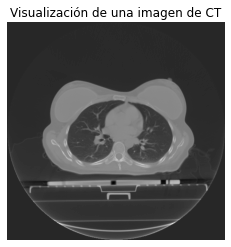

In [7]:
matriz_pixeles[matriz_pixeles == -3024] = -1024
plt.imshow(matriz_pixeles, cmap=plt.cm.gray)
plt.axis('off')
plt.savefig(ruta_salida +'CT_C1.png',bbox_inches='tight', pad_inches = 0)
plt.title('Visualización de una imagen de CT')
plt.show()

In [8]:
print(f"Los rangos de Unidades Hounsfield de la imagen son: [{np.min(matriz_pixeles)}HU,{np.max(matriz_pixeles)}HU]")
print(f"La escala se extiende en: {abs(np.max(matriz_pixeles)-np.min(matriz_pixeles))} HU.")

Los rangos de Unidades Hounsfield de la imagen son: [-1460HU,1349HU]
La escala se extiende en: 2809 HU.


### Corte de mesa en las imágenes
Por motivos de visualización y para el posterior procesamiento de las imágenes es necesario eliminar cualquier elemento que no pertenezca a estructuras anatómicas, tal es el caso de la camilla. 
Para eso se visualizarán todas las imagenes del examen.

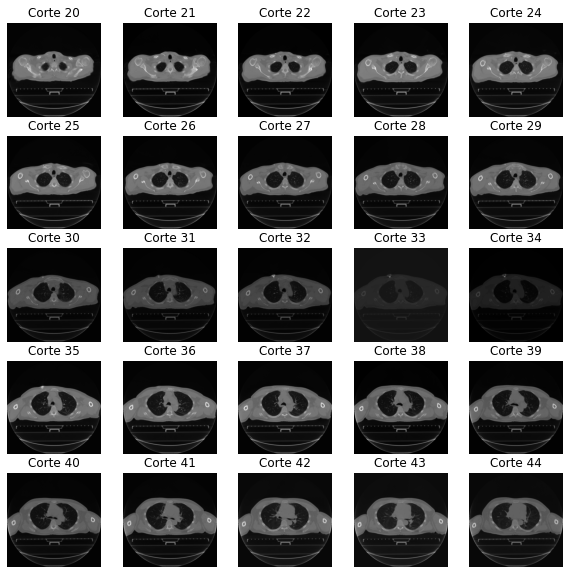

In [9]:
ruta_examen ='datos-torax-A/paciente6-A'
def sample_stack(stack, rows=5, cols=5, start_with=10, show_every=1):
    """Función que grafica las imágenes a partir de una matriz de 3 dimensiones"""
    fig,ax = plt.subplots(rows,cols,figsize=[10,10])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('Corte %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap=plt.cm.gray)
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()
    
examen = imp.extrac_matrix(imp.load_scan(ruta_examen)) 
sample_stack(examen, rows=5, cols=5, start_with=20, show_every=1)

Se puede observar que en todas las imágenes la camilla se encuentra en una posición en específico, para verificar la posición se procederá a tomar solamente una de las imágenes y a recortar la sección correspondiente a la camilla.

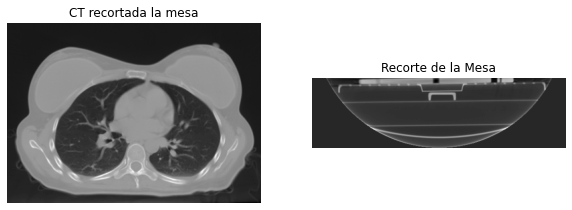

In [10]:
fig, ([ax1, ax2]) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(matriz_pixeles[100:370,70:450], cmap=plt.cm.gray)
ax1.set_title('CT recortada la mesa')
ax1.axis('off')
plt.imshow(matriz_pixeles[370:512,:],cmap=plt.cm.gray)
ax2.set_title('Recorte de la Mesa')
ax2.axis('off')
plt.show()

Se encontró que los píxeles que se encuentran fuera del rango del [x --> 0:370], los píxeles que no corresponden a estos rangos pertenecen a la camilla por lo que a esta zona se le asignará las unidades Hounsfield correspondientes al aire, cuyo valor es de -1024.
    

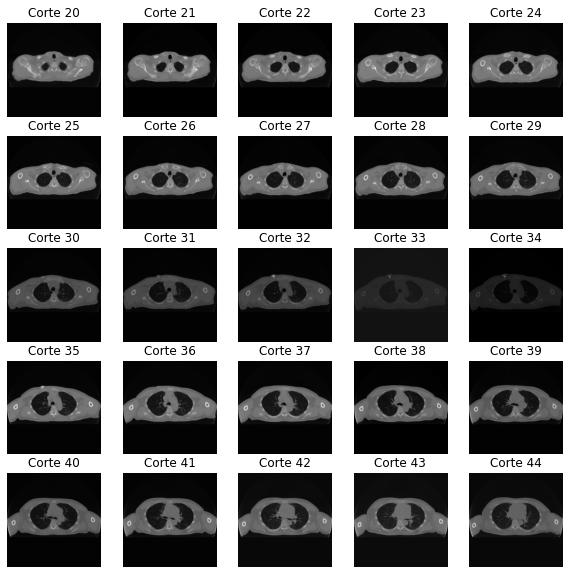

In [11]:
rm_matriz_pixeles = imp.remov_cama(examen)
rm_matriz_pixeles[370:512,:] = -1024
sample_stack(rm_matriz_pixeles, rows=5, cols=5, start_with=20, show_every=1)

Se puede observar que mediante esta modificación se ha eliminado la camilla y se le ha reemplazado por aire.

### Visualización de una imagen de TC
La escala Hounsfield se extiende a largo de 2809 unidades, cuando se procede a realizar la visualización la biblioteca Matplotlib distribuirá la escala Hounsfield para que comprenda todos los valores que abarca la escala de grises, por lo que difícilmente es distinguible cada material dentro de la imagen,  ya que cada tonalidad de gris en la imagen comprende 11 unidades Hounsfield, lo que implica la pérdida de información al momento de la visualización y genera una imagen como la presentada anteriormente. Por lo que para una visualización adecuada se crearon las ventanas. Las ventanas permiten en definitiva extraer la información de la matriz de píxeles mostrando sólamente rangos específicos que comprendan los valores del órgano o tejido que se desee estudiar.

#### Visualización ventana [-100, 300]  HU 

Esta ventana es la que más se asemeja al estilo utilizado por el software iQ-LITE 3.0.0.

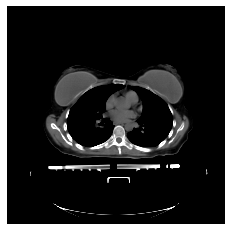

In [12]:
plt.imshow(matriz_pixeles, cmap=plt.cm.gray, vmin=-100, vmax=300)
plt.axis('off')
plt.show()

#### Visualización ventana [-1000, 1000]  HU 

Esta ventana  cubre los materiales aire, tejido blando y hueso.

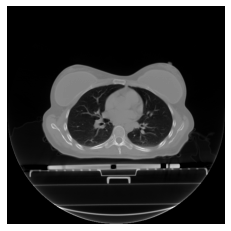

In [13]:
plt.imshow(matriz_pixeles, cmap=plt.cm.gray, vmin=-1000, vmax=1000)
plt.axis('off')
plt.savefig(ruta_salida +'CT_1000.png',bbox_inches='tight', pad_inches = 0)
plt.show()

#### Visualización ventana [200, 500]  HU 

Esta ventana muestra el hueso cortical.

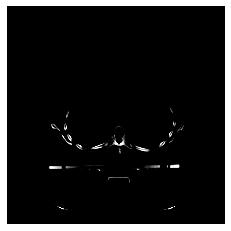

In [14]:
plt.imshow(matriz_pixeles, cmap=plt.cm.gray, vmin=200, vmax=500)
plt.axis('off')
plt.savefig(ruta_salida +'CT_500.png',bbox_inches='tight', pad_inches = 0)
plt.show()

## Visualización de un examen completo de CT


Para la visualización de las imágenes de TC en diferentes planos anatómicos se implementaron los 4 primeros pasos que se realizaron para el proceso de visualización de una sola imagen, con la diferencia de que para este caso el desarrollo es iterativo y debe ser aplicado para todos y cada uno de los archivos DICOM que pertenecen a la misma serie, por lo que la obtención, transformación y corrección de la matriz de píxeles es llevada a cabo para cada una de las imágenes de un mismo examen.
Luego se procede a generar la matriz de 3D que es guardada como un objeto `numpy.ndarray`.

>**Nota**: Los procesos iterativos fueron implementados en funciones guardadas en el archivo imprimir_imagen y son importadas a este notebook como `ipm`.

In [15]:
ruta = 'datos-torax-A/paciente3-A'
slices = imp.load_scan(ruta)
imagen = imp.extrac_matrix(slices) # se cargan las imágenes 
imagen =  imp.remov_cama(imagen) # función que remueve la camilla
print(f"La matriz es del tipo de dato {type(imagen)} de la biblioteca numpy de dimensión {imagen.shape}.")

La matriz es del tipo de dato <class 'numpy.ndarray'> de la biblioteca numpy de dimensión (63, 512, 512).


### Escalamiento de Ejes

Este paso permite mostrar la imagen de acuerdo a las distancias físicas reales. Se utilizan diferentes atributos de los archivos DICOM, para más información puede visitar el siguiente link [<a href="http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.7.6.2.html">1,</a> <a href="http://dicom.nema.org/dicom/2013/output/chtml/part03/sect_10.7.html">2,</a>] donde se describe de una manera más detallada el significado y tags de los atributos. A continuación se muestra un esquemático con el significado de algunos de los atributos que se utilizarán.

<img src="imagenes/space_p.png">

- **Pixel Spacing:** es una lista de 2 valores [Row Spacing, Column Spacing], que especifica la distancia física entre los centros de cada píxel bidimensional de la imagen axial de TC (0028,0030).

- **Image Position Patient:** este atributo detalla los valores de coordenadas x, y, z de la esquina superior izquierda (centro del primer vóxel transmitido) de la imagen en mm (0020,0032).
- **InstanceNumber:** determina el orden de las imágenes respecto de su adquisición (0020,0013).


In [16]:
print('------------------------------------------------------------------------------------------------------')
print('PRIMERA IMAGEN DE ACUERDO AL ORDEN DE ADQUISICIÓN')
print('PixelSpacing = ', slices[0].PixelSpacing)
print('ImagePositionPatient = ', slices[0].ImagePositionPatient)
print('InstanceNumber = ', slices[0].InstanceNumber)
print('------------------------------------------------------------------------------------------------------')
print('SEGUNDA IMAGEN DE ACUERDO AL ORDEN DE ADQUISICIÓN')
print('PixelSpacing = ', slices[1].PixelSpacing)
print('ImagePositionPatient = ', slices[1].ImagePositionPatient)
print('InstanceNumber = ', slices[1].InstanceNumber)


------------------------------------------------------------------------------------------------------
PRIMERA IMAGEN DE ACUERDO AL ORDEN DE ADQUISICIÓN
PixelSpacing =  ['0.976562', '0.976562']
ImagePositionPatient =  ['-250.000', '-250.000', '200.000']
InstanceNumber =  '1'
------------------------------------------------------------------------------------------------------
SEGUNDA IMAGEN DE ACUERDO AL ORDEN DE ADQUISICIÓN
PixelSpacing =  ['0.976562', '0.976562']
ImagePositionPatient =  ['-250.000', '-250.000', '195.000']
InstanceNumber =  '2'


Ahora se procede al cálculo de las distancias entre ejes para la  posterior graficación de las imágenes.

In [17]:
ss = slices[0].SliceThickness # se calcula la distancia entre slices
ps = slices[0].PixelSpacing # distancia entre píxeles
ax_aspect = ps[1]/ps[0] # relación entre los ejes x/y
sag_aspect = ss/ps[1] # relación entre los ejes z/y
cor_aspect = ss/ps[0] # relación entre los ejes z/x
print(f'La distancia entre cortes consecutivos es de: {ss*1.0}')
print(f'La relación entre los ejes x/y: {ax_aspect}')
print(f'La relación entre los ejes z/y: {sag_aspect}')
print(f'La relación entre los ejes z/x: {cor_aspect}')


La distancia entre cortes consecutivos es de: 5.0
La relación entre los ejes x/y: 1.0
La relación entre los ejes z/y: 5.120002621441342
La relación entre los ejes z/x: 5.120002621441342


### Visualización plano Axial

Para este plano se utiliza la relación x/y, y la función `visualizar_pantalla_mult_ax_fun` que se creo en el archivo `imprimir_imagen`, que grafica un examen completo de CT en el plano coronal y donde se puede elegir el número  mínimo de filas para la visualización, para más información revisar este archivo, ya que implementa y simplifica todos los procesos anteriores para un examen completo.

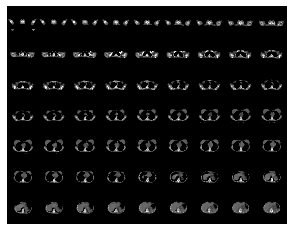

In [18]:
min_filas = 5
nombre_img = ruta_salida + 'mult2.png'
imp.visualizar_pantalla_mult_ax_fun(ruta, min_filas, nombre_img, 1000 )

In [19]:
image = PIL.Image.open(nombre_img)
width, height = image.size
print('La imagen resultante tiene las dimensiones en el eje X = ' ,width,'en el eje y = ' ,height, '.')

La imagen resultante tiene las dimensiones en el eje X =  4608 en el eje y =  3584 .


La imagen final es guardada automáticamente por el programa en formato PNG,
para el caso estudiado se obtuvo una imagen con un tamaño de
7765 × 6040 píxeles que corresponde exactamente a la multiplicación de 512 × 9 y
512 × 7, que es la distribución de cada uno de los cortes en la imagen final, por lo
que se puede decir que al realizar esta visualización no se ha perdido información.

### Visualización plano Coronal

Se procede a graficar una de las imágenes de las 512 que se generan a partir de todos los cortes del examen, para la relación entre los ejes se utiliza la relación z/x.

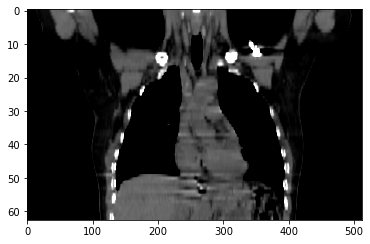

In [20]:
a2 = plt.subplot(1, 1, 1)
plt.imshow(imagen[:, 240, :],cmap=plt.cm.gray, vmin=-100, vmax=300)
a2.set_aspect(cor_aspect)
plt.show()

 Aquí se utiliza la función `visualizar_pantalla_mult_cor_fun` del archivo `imprimir_imagen`, que fue diseñada con el fin de graficar automáticamente este plano anatómico.


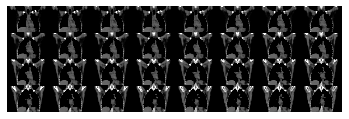

In [21]:
min_valor = np.min(imagen)
max_valor = np.max(imagen)
min_filas = 4
nombre_img = ruta_salida + 'plano_coronal.png'
imp.visualizar_pantalla_mult_cor_fun(ruta, min_filas, nombre_img, 100)

### Visualización plano Sagital

Se procede a graficar una de las imágenes de las 512 que se generan a partir de todos los cortes del examen para el plano sagital, para la relación entre los ejes se utiliza la relación z/y.

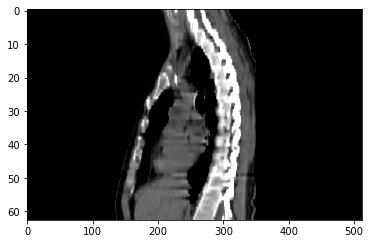

In [22]:
a2 = plt.subplot(1, 1, 1)
plt.imshow(imagen[:,:, 249],cmap=plt.cm.gray, vmin=-100, vmax=300)
a2.set_aspect(sag_aspect)
plt.show()

 Aquí se utiliza la función `visualizar_pantalla_mult_sag_fun` del archivo `imprimir_imagen`, que fue diseñada con el fin de graficar automáticamente este plano anatómico.

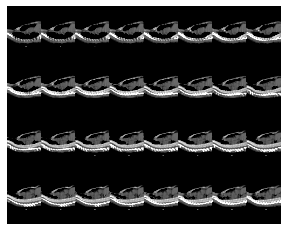

In [23]:
min_filas = 4
nombre_img = ruta_salida + 'plano_sagital.png'
imp.visualizar_pantalla_mult_sag_fun(ruta,min_filas, nombre_img, 500)

[Top of Page](#top)

<img style="float: right;" src="https://fisica.epn.edu.ec/images/LOGO_fisica-01-01.png" alt="Space Telescope Logo" width="300px"/> 